# Spiral 3DREAM
(A sequence plot is placed at the end)

## Python standard libraries

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import ismrmrd
import os
import datetime
from pathlib import Path # create directories

In [85]:
from pypulseq.make_arbitrary_grad import make_arbitrary_grad
from pypulseq.Sequence.sequence import Sequence
from pypulseq.make_adc import make_adc
from pypulseq.make_sinc_pulse import make_sinc_pulse
from pypulseq.make_gauss_pulse import make_gauss_pulse
from pypulseq.make_block_pulse import make_block_pulse
from pypulseq.make_trap_pulse import make_trapezoid
from pypulseq.make_delay import make_delay
from pypulseq.make_digital_output_pulse import make_digital_output_pulse
from pypulseq.opts import Opts
from pypulseq.calc_duration import calc_duration

In [86]:
import spiraltraj
import pulseq_helper as ph
from prot import create_hdr
from gre_refscan import gre_refscan
from gre_3Drefscan import gre_3Drefscan
from gre_3DrefscanLinear import gre_3DrefscanLinear
import phase_enc_helper as pe

## Parameters

In [87]:
"""
PyPulseq units (SI): 
time:       [s] (not [ms] as in documentation)
spatial:    [m]
gradients:  [Hz/m] (gamma*T/m)
grad area:  [1/m]
flip angle: [rad]

Some units get converted below, others have to stay in non-SI units as spiral calculation needs different units

Add new parameters also to the protocol parameter h5 file at the end of this script.
Use custom version of Pypulseq: https://github.com/mavel101/pypulseq (branch dev_mv)
"""

# General
seq_dest        = "sim"         # save parameter: 'None': save nothing, 'scanner': save seq & prot in seq/prot folder & in exchange folder 'sim': save seq in sim folder
seq_name        = '3Dream'      # sequence/protocol filename
plot            = True         # plot sequence (refscans & noisescans will be deactivated)

# STEAM preparation
# rf pulses:
flip_angle_ste  = 50            # flip angle of the excitation pulses of the STEAM prep-sequence [°]
rf_dur_ste      = 0.4           # RF duration [ms]

# Sequence - Contrast and Geometry
fov             = 200           # field of view [mm]
TR              = 6.25          # repetition time [ms]
TE_ste          = 0.71           # STE/ STE* echo time [ms]
TE_fid          = 3.66           # FID echo time [ms]
res             = 5             # in plane resolution [mm]                   
slice_res       = 5             # slice thickness [mm]
slices          = 1             # number of slices
Nz              = 40            # number of partitions
averages        = 1             # number of averages
contrasts       = 2             # number of contrasts (DREAM: STE/ STE* and FID)

# times of STEAM prep:
time_scheme = 3                 # 1: TS = TE_ste, 2: TS = TE_ste + TE_fid , 3: TS = TE_fid - TE_ste; for all: STE/ STE* first
if time_scheme == 1:            # time span between the two STEAM preparation pulses [ms]
    TS = TE_ste
    B0map = True
elif time_scheme == 2:
    TS = TE_ste + TE_fid
    B0map = True
elif time_scheme == 3:
    TS = TE_fid - TE_ste
    B0map = False

TM              = 1.42          # mixing time: time span between the 2nd alpha and 1st beta pulse -> small compared to T1 relaxation time [ms]
TD              = TM + TS       # time span between the 1st alpha and 1st beta pulse [ms]

refscan         = True          # Cartesian reference scan for sensmaps
refscan_3D      = 1             # 0: refscan is 2D linear multislice, 1: refscan is Cartesian spiral two phase encoding order, 2: refscan is linear phase encoding order
tbp_refscan     = 23            # time bandwidth product refscan pulse
dur_refscan     = 2             # refscan pulse duration [ms]
half            = False         # half number of slices acquired in the refscan
prepscans       = 0             # number of preparation/dummy scans before spiral sequence
noisescans      = 16            # number of noise scans

# ADC
os_factor       = 2             # oversampling factor (automatic 2x os from Siemens is not applied)

# RF
flip_angle      = 5             # flip angle of excitation pulse [°]
rf_dur          = 0.2           # RF duration [ms]
tbp_exc         = 6             # time bandwidth product excitation pulse
rf_spoiling     = False         # RF spoiling

fatsat          = True          # Fat saturation pulse
fatsat_dur      = 2.1           # duration of fatsat pulse [ms] (increase at low TR to avoid SAR problems)

# Gradients
max_slew        = 180           # maximum slewrate [T/m/s] (system limit)
spiral_slew     = 150           # maximum slew rate of spiral gradients - for pre Emph: set lower than max_slew
max_grad        = 55            # maximum gradient amplitude [mT/m] (system limit) - used also for diffusion gradients
max_grad_sp     = 42            # maximum gradient amplitude of spiral gradients - for pre_emph: set lower than max_grad

Nintl           = 9             # spiral interleaves
redfac          = 3             # reduction/acceleration factor
spiraltype      = 1             # 1: Spiral Out, 4: ROI, WIP: other spiral waveforms
spiral_os       = 1             # spiral oversampling in center

Rz              = 2             # reduction/acceleration factor in kz direction; here just 0 or 2 possible
CAIPI           = True          # CAIPI-pattern with Delta=2; here just for Rz=2 and Nintl=9 or Nintl=15

eddy_delay      = True          # delay after Gmiddle before 2nd spiral against eddy currents

skope           = False         # add trigger for skope measurement
sync_scans      = 10            # number of Skope sync_scans

# T1 estimation for global filter approach
t1_choice       = 0             # 0: approximately Gufi Phantom at 7T, 1: brain (gray matter) 
if t1_choice == 0:
    t1 = 784e-3                 # [s]
    flip_refscan = 6            # [°]
elif t1_choice == 1:
    t1 = 2                      # [s]
    flip_refscan = 4            # [°]

## Limits, checks and preparations

In [88]:
# Set System limits
rf_dead_time = 100e-6       # lead time before rf can be applied
rf_ringdown_time = 30e-6    # coil hold time (20e-6) + frequency reset time (10e-6)
system = Opts(max_grad=max_grad, grad_unit='mT/m', max_slew=max_slew, slew_unit='T/m/s', rf_dead_time=rf_dead_time, rf_ringdown_time=rf_ringdown_time)

# convert parameters to Pulseq units
rf_dur_ste  *= 1e-3     # [s]
TR          *= 1e-3     # [s]
TE_ste      *= 1e-3     # [s]
TE_fid      *= 1e-3     # [s]
TS          *= 1e-3     # [s]
TD          *= 1e-3     # [s]
TM          *= 1e-3     # [s]
rf_dur      *= 1e-3     # [s]
slice_res   *= 1e-3     # [m]
fatsat_dur  *= 1e-3     # [s]
dur_refscan *= 1e-3     # [s]

# standard rotation matrix for Pulseq sequence from logical to patient coordinate system
rotmat = -1*np.eye(3)

if skope:
    skope_delay = 200e-6 # delay/gradient free interval for Skope measurement
    if TR < 200e-3:
        print('Warning: TR should be at least 200 ms for Skope measurements')
else:
    skope_delay = 0

if Nintl/redfac%1 != 0:
    raise ValueError('Number of interleaves is not multiple of reduction factor')

if spiraltype!=1 and spiraltype!=4:
    ValueError('Right now only spiraltype 1 (spiral out) and 4 (ROI) possible.')

## RF pulse and slab/slice selection gradient

In [89]:
# make rf pulse and calculate duration of excitation and rewinding -> binomial pulses for water excitation
flip_angle_bin = flip_angle/2
rf, gz, gz_rew, rf_del = make_sinc_pulse(flip_angle=flip_angle_bin*np.pi/180, system=system, duration=rf_dur, slice_thickness=fov*1e-3,
                            apodization=0.5, time_bw_product=tbp_exc, use='excitation', return_gz=True, return_delay=True)
exc_to_rew = rf_del.delay - rf_dur/2 - rf.delay # time from middle of rf pulse to rewinder, rf_del.delay equals the block length
rew_dur = calc_duration(gz_rew)

amp_gz_rew_bin, ftop_gz_rew_bin, ramp_gz_rew_bin = ph.trap_from_area(2*gz_rew.area, system, slewrate=120)
gz_rew_bin= make_trapezoid(channel='z', system=system, amplitude=amp_gz_rew_bin, flat_time=ftop_gz_rew_bin, rise_time=ramp_gz_rew_bin)

tau_bin = - 1 / (2*ph.fw_shift) # [s]
min_tau_bin = calc_duration(rf,gz,rf_del) + calc_duration(gz_rew_bin)
if min_tau_bin > tau_bin:
    min_tau_bin = ph.round_up_to_raster(min_tau_bin, decimals=5)*1e3
    raise ValueError('tau_bin must be at least {} ms'.format(min_tau_bin)) 
delay_tau_bin = round(tau_bin - min_tau_bin,5)
tau_bin_delay = make_delay(d=delay_tau_bin)

# RF spoiling parameters
rf_spoiling_inc = 50 # increment of RF spoiling [°]
rf_phase        = 0 
rf_inc          = 0

# Fat saturation
if fatsat:
    fatsat_bw = 1000 # bandwidth [Hz] (1000 Hz is approx. used by Siemens)
    fatsat_fa = 110 # flip angle [°]

    rf_fatsat, fatsat_del = make_gauss_pulse(flip_angle=fatsat_fa*np.pi/180, duration=fatsat_dur, bandwidth=fatsat_bw, freq_offset=ph.fw_shift, system=system, return_delay=True)

## STEAM preparation

In [90]:
# rf pulses (block pulses)
rf_ste, rf_ste_delay = make_block_pulse(flip_angle=flip_angle_ste*np.pi/180, duration=rf_dur_ste, return_delay=True,system=system, use='excitation')

# Area A1 for k-space separation
c = 3                   # determines the separation in k-space
Nx = int(fov/res+0.5)
delta_k = 1/(fov*1e-3)  #[1/m]
A1 = c * Nz*delta_k/2   #[1/m]

# prephaser Gm1 (in the imaging train)
gm1_area = -A1          #[1/m]

# rephaser Gmiddle (in the imaging train)
gmiddle_area = A1       #[1/m]
amp_gmiddle, ftop_gmiddle, ramp_gmiddle = ph.trap_from_area(gmiddle_area, system)
gmiddle = make_trapezoid(channel='z', system=system, amplitude=amp_gmiddle, flat_time=ftop_gmiddle, rise_time=ramp_gmiddle)

# dephaser Gm2 (in the STEAM prep. seq.)
if (time_scheme == 1 or time_scheme == 2):
    gm2_area = -A1      #[1/m]
elif time_scheme == 3:
    gm2_area = A1       #[1/m]
amp_gm2, ftop_gm2, ramp_gm2 = ph.trap_from_area(gm2_area, system)
gm2 = make_trapezoid(channel='z', system=system, amplitude=amp_gm2, flat_time=ftop_gm2, rise_time=ramp_gm2) # in phase encoding direction

# spoiler (after second rf pulse)
gx_spoil_ste = make_trapezoid(channel='x', area=4 /(res*1e-3), system=system, max_slew=80*system.gamma)
gy_spoil_ste = make_trapezoid(channel='y', area=4 /(res*1e-3), system=system, max_slew=80*system.gamma)
gz_spoil_ste = make_trapezoid(channel='z', area=4 /(slice_res),system=system, max_slew=80*system.gamma)

# Delays
x_ste = calc_duration(rf_ste) - rf_ste.dead_time    # [s]
a_ste = rf_ste.dead_time + x_ste/2                  # [s]
b_ste = rf_ste_delay.delay - a_ste                  # [s]

# take minimum TS rounded up to .1 ms
min_TS = b_ste + calc_duration(gm2) + a_ste         # [s]
if min_TS > TS:
    min_TS = ph.round_up_to_raster(min_TS, decimals=5)*1e3
    raise ValueError('TS must be at least {} ms'.format(min_TS))
delay_TS = round(TS - min_TS,5)
ts_delay = make_delay(d=delay_TS)

# take minimum TM rounded up to .1 ms
min_TM = b_ste + calc_duration(gz_spoil_ste, gx_spoil_ste, gy_spoil_ste) + rf.delay + gz.flat_time/2 # [s]
if min_TM > TM:
    min_TM = ph.round_up_to_raster(min_TM, decimals=5)*1e3
    raise ValueError('TM must be at least {} ms'.format(min_TM)) 
delay_TM = round(TM - min_TM,5)
tm_delay = make_delay(d=delay_TM)

## Spiral Readout Gradients

In [91]:
# Parameters spiral trajectory:

# parameter         description               default value
# ---------        -------------              --------------

# nitlv:      number of spiral interleaves        15
# res:        resolution                          1 mm
# fov:        target field of view                192 mm
# max_amp:    maximum gradient amplitude          42 mT/m
# min_rise:   minimum gradient risetime           5 us/(mT/m)
# spiraltype: 1: spiral out                   
#             2: spiral in                        
#             3: double spiral                    x
#             4: ROI
#             5: RIO
# spiral_os:  spiral oversampling in center       1

# Rotation of Spirals
if spiraltype==3:
    max_rot     = np.pi    # maximum rotation angle of spirals [rad]
else:
    max_rot     = 2*np.pi  

# read in Spirals [T/m]
min_rise_sp = 1/spiral_slew * 1e3
spiral_calc = spiraltraj.calc_traj(nitlv=Nintl, fov=fov, res=res, spiraltype=spiraltype, min_rise=min_rise_sp, max_amp=max_grad_sp, spiral_os=spiral_os) # [mT/m]
spiral_calc = np.asarray(spiral_calc)
spiral_x = 1e-3*spiral_calc[:,0]
spiral_y = 1e-3*spiral_calc[:,1]

N_spiral = len(spiral_x)
readout_dur = N_spiral*system.grad_raster_time # readout duration [s]

# write spiral readout blocks to list
spirals = [{'deph': [None, None], 'spiral': [None, None], 'reph': [None, None]} for k in range(Nintl)]
reph_dur = []
save_sp = np.zeros((Nintl, 2, N_spiral)) # save gradients for FIRE reco
rot_angle = np.linspace(0, max_rot, Nintl, endpoint=False)
for k in range(Nintl):
    # rotate spiral gradients for shot selection
    sp_x, sp_y = ph.rot_grad(spiral_x, spiral_y, rot_angle[k])

    save_sp[k,0,:] = sp_x # for FIRE reco
    save_sp[k,1,:] = sp_y # for FIRE reco

    # unit to [Hz/m], make spiral gradients (conversion into pulseq units)
    sp_x *= system.gamma
    sp_y *= system.gamma
    if spiraltype==1:
        spiral_delay = 2e-5 # delay the spirals to have some ADC samples before the start of the spiral
    else:
        spiral_delay = 0 # no spiral delay as sampling points should be mirrored in ROI
    spirals[k]['spiral'][0] = make_arbitrary_grad(channel='x', waveform=sp_x, delay=spiral_delay, system=system)
    spirals[k]['spiral'][1] = make_arbitrary_grad(channel='y', waveform=sp_y, delay=spiral_delay, system=system)

    if spiraltype==1:
        # calculate rephaser area
        area_x = sp_x.sum()*system.grad_raster_time
        area_y = sp_y.sum()*system.grad_raster_time

        # calculate rephasers and make gradients
        amp_x, ftop_x, ramp_x = ph.trap_from_area(-area_x, system, slewrate = 100) # reduce slew rate to 100 T/m/s to avoid stimulation
        amp_y, ftop_y, ramp_y = ph.trap_from_area(-area_y, system, slewrate = 100)
        spirals[k]['reph'][0] = make_trapezoid(channel='x', system=system, amplitude=amp_x, duration=2*ramp_x+ftop_x, rise_time=ramp_x)
        spirals[k]['reph'][1] = make_trapezoid(channel='y', system=system, amplitude=amp_y, duration=2*ramp_y+ftop_y, rise_time=ramp_y)
        reph_dur.append(max(ftop_x+2*ramp_x, ftop_y+2*ramp_y))


# check for acoustic resonances (checks only spirals)
freq_max = ph.check_resonances([spiral_x,spiral_y])

# make small delay after gmiddle and before 2nd spiral against eddy currents
if eddy_delay:
    delay_2spiral = 1000e-6 #[s]
else:
    delay_2spiral = 0       #[s]

del_2spiral = make_delay(d=delay_2spiral)

Acoustic resonance check succesful.


## Second phase encoding (in z-direction)

In [92]:
phase_comp,phase_areas = pe.CentricOrder(N=Nz, fov=fov*1e-3, comp=True)  #[1/m]

if Rz == 2:
    phase_comp = phase_comp[phase_comp%2==0]
    phase_areas = phase_comp * delta_k
elif Rz != 0 and Rz != 2:
    raise ValueError('Rz has to be {} or {}'.format(0,2))

## Interleaves ("first phase encoding")

In [93]:
n_arr = np.zeros([np.size(phase_areas),int(Nintl/redfac)], dtype=float)

if CAIPI:
    if Rz==2:
        if Nintl==9:
            n_arr[::3,:]  = np.arange(0,int(Nintl/redfac))
            n_arr[1::3,:] = np.array([2/redfac,5/redfac,8/redfac])
            n_arr[2::3,:] = np.array([1/redfac,4/redfac,7/redfac])
        if Nintl==15:
            n_arr[::3,:]  = np.arange(0,int(Nintl/redfac))
            n_arr[1::3,:] = np.array([2/redfac,5/redfac,8/redfac,11/redfac,14/redfac])
            n_arr[2::3,:] = np.array([1/redfac,4/redfac,7/redfac,10/redfac,13/redfac])
    if Rz!=2:
        raise ValueError('For CAIPI-pattern Rz has to be {}'.format(2))
else:
    n_arr[:]  = np.arange(0,int(Nintl/redfac))

## Gradient Spoiler on slice axis

In [94]:
spoiler_area = 4 / (slice_res)
dur = np.zeros(np.size(phase_areas))   
for i in range(np.size(phase_areas)):
    area = -phase_areas[i] + spoiler_area
    amp_gz_spoil, ftop_gz_spoil, ramp_gz_spoil= ph.trap_from_area(area, system, slewrate=120)
    gz_spoil = make_trapezoid(channel='z', system=system, amplitude=amp_gz_spoil, duration=2*ramp_gz_spoil+ftop_gz_spoil, rise_time=ramp_gz_spoil)
    dur[i] = calc_duration(gz_spoil)
max_dur = dur.max()
print("max duration for gz_spoil=",max_dur)

# for fatsat:
spoiler_area_fat = 4 / (slice_res)
amp_spoil_fat, ftop_spoil_fat, ramp_spoil_fat = ph.trap_from_area(spoiler_area_fat, system, slewrate=100) # reduce slew rate to 100 T/m/s to avoid stimulation
gz_spoil_fat= make_trapezoid(channel='z',system=system, amplitude=amp_spoil_fat, duration=2*ramp_spoil_fat+ftop_spoil_fat, rise_time=ramp_spoil_fat, delay=100e-6)
spoiler_dur_fat = calc_duration(gz_spoil_fat)

max duration for gz_spoil= 0.00084


## ADC

In [95]:
max_grad_sp_cmb = 1e3*np.max(np.sqrt(abs(spiral_x)**2+abs(spiral_y)**2))
dwelltime = 1/(system.gamma*max_grad_sp_cmb*fov*os_factor)*1e6  # ADC dwelltime [s]
dwelltime = ph.trunc_to_raster(dwelltime, decimals=7)           # truncate dwelltime to 100 nanoseconds (scanner limit)
min_dwelltime = 1e-6
if dwelltime < min_dwelltime:
    dwelltime = min_dwelltime
print("ADC dwelltime: {}".format(dwelltime))

num_samples = round((readout_dur+spiral_delay)/dwelltime)
if num_samples%2==1:
    num_samples += 1 # even number of samples

if num_samples <= 8192:
    num_segments = 1
    print('Number of ADCs: {}.'.format(num_samples))
else:
    # the segment duration has to be on the gradient raster
    # increase number of segments or samples/segments to achieve this
    # number of samples and number of samples per segment should always be an even number
    num_segments = 2
    if (num_samples/num_segments % 2 != 0):
        num_samples += 2
    segm_dur = 1e5 * dwelltime * num_samples/num_segments       # segment duration [10us - gradient raster]
    while (not round(segm_dur,ndigits=5).is_integer() or num_samples/num_segments > 8192):
        if num_samples/num_segments > 8192:
            num_segments += 1
            while (num_samples/num_segments % 2 != 0):
                num_samples += 2
        else:
            num_samples += 2*num_segments
        segm_dur = 1e5 * dwelltime * num_samples/num_segments 
    print('ADC has to be segmented!! Number of ADCs: {}. Per segment: {}. Segments: {}.'.format(num_samples,num_samples/num_segments,num_segments))

    # self check
    if (num_samples/num_segments % 2 != 0 or num_samples % 2 != 0 or not round(segm_dur,ndigits=5).is_integer()):
        raise ValueError("Check if number of samples and number of samples per segment are even. Check if segment duration is on gradient raster time.")

if num_samples > 65535: # max of uint16 used by ISMRMRD
    raise ValueError("Too many samples for ISMRMRD format - lower the oversampling factor or take more interleaves")

adc = make_adc(system=system, num_samples=num_samples, dwell=dwelltime)
adc_dur = num_samples * dwelltime
adc_delay = ph.round_up_to_raster(adc_dur+200e-6, decimals=5)   # add small delay after readout for ADC frequency reset event and to avoid stimulation by rephaser
adc_delay = make_delay(d=adc_delay)
if skope:
    print('Minimum Skope acquisition time: {:.2f} ms'.format((adc_dur+1e-3)*1e3)) # add 1 ms to be safe

ADC dwelltime: 3.2e-06
Number of ADCs: 416.


## duration from gz_pre

In [96]:
dur_gz_pre = np.zeros(np.size(phase_areas))   
for i in range(np.size(phase_areas)):
    area = phase_areas[i] + gz_rew.area + gm1_area
    amp_gz_spoil, ftop_gz_spoil, ramp_gz_spoil= ph.trap_from_area(area, system, slewrate=120)
    gz_pre = make_trapezoid(channel='z', system=system, amplitude=amp_gz_spoil, duration=2*ramp_gz_spoil+ftop_gz_spoil, rise_time=ramp_gz_spoil)
    dur_gz_pre[i] = calc_duration(gz_pre)
max_dur_gz_pre = dur_gz_pre.max()
print("max duration for gz_pre=",max_dur_gz_pre)

max duration for gz_pre= 0.00058


## delay calculation for the imaging train

In [97]:
# take minimum TE_ste
min_TE_ste = gz.fall_time + gz.flat_time/2 + max_dur_gz_pre # [s]
if min_TE_ste > TE_ste:
    min_TE_ste = ph.round_up_to_raster(min_TE_ste, decimals=5)*1e3
    raise ValueError('TE_ste has to be at least {} ms'.format(min_TE_ste)) 
delay_TE_ste = round(TE_ste - min_TE_ste,5)
te_ste_delay = make_delay(d=delay_TE_ste)

## Set up protocol for FIRE reco and write header

In [98]:
date = datetime.date.today().strftime('%Y%m%d')
filename = date + '_' + seq_name

if seq_dest == 'scanner':

    # create new directory if needed
    Path("../Protocols/"+date).mkdir(parents=True, exist_ok=True)
    filepath = "../Protocols/"+date+"/{}.h5".format(filename)

    # set up protocol file and create header
    if os.path.exists(filepath):
        raise ValueError("Protocol name already exists. Choose different name")
    prot = ismrmrd.Dataset(filepath)
    hdr = ismrmrd.xsd.ismrmrdHeader()

    params_hdr = {"trajtype": "spiral", "fov": fov, "res": res, "slices": slices, "slice_res": slice_res, "npartitions": Nz, "nintl":int(Nintl/redfac), "avg": averages,
                    "nsegments": num_segments, "dwelltime": dwelltime, "traj_delay": spiral_delay, "ncontrast": contrasts}
    create_hdr(hdr, params_hdr)
    prot.write_xml_header(hdr.toxml('utf-8'))
    
    # append dream array for B1 map calculation (with global filter)
    dream = np.array([0,flip_angle_ste,TR,flip_angle,prepscans,t1])
    prot.append_array('dream', dream)
    
    # append array for B0 mapping
    if B0map:
        te_diff = TE_ste + TS - TE_fid
        dreamB0 = np.array([te_diff])
        prot.append_array('dreamB0', dreamB0)

else:
    prot = None

## Add sequence blocks to sequence & write acquisitions to protocol

In [99]:
# Set up the sequence
seq = Sequence()

# Definitions section in seq file - WIP: What is "Delays" definition doing??
seq.set_definition("Name", filename) # protocol name is saved in Siemens header for FIRE reco
seq.set_definition("FOV", [1e-3*fov, 1e-3*fov, 1e-3*fov]) # for FOV positioning
#seq.set_definition("Slice_Thickness", "%f" % (slice_res*slices))
if num_segments > 1:
    seq.set_definition("MaxAdcSegmentLength", "%d" % int(num_samples/num_segments+0.5)) # for automatic ADC segment length setting

# Noise scans
if plot:
    print("We do plotting, so noisescans are set to 0.")
    noisescans = 0
noise_samples = 256
noise_dwelltime = 2e-6
noise_adc = make_adc(system=system, num_samples=256, dwell=noise_dwelltime)
noise_delay = make_delay(d=ph.round_up_to_raster(noise_adc.duration+1e-3,decimals=5)) # add some more time to the ADC delay to be safe
for k in range(noisescans):
    seq.add_block(noise_adc, noise_delay)
    if seq_dest == 'scanner':
        acq = ismrmrd.Acquisition()
        acq.setFlag(ismrmrd.ACQ_IS_NOISE_MEASUREMENT)
        prot.append_acquisition(acq)
if not plot:
    print("after noise scans: {} sec".format(seq.duration()[0]))

# Perform cartesian reference scan: if selected / for accelerated spirals / for long readouts
if refscan == False:
    if redfac > 1:
        refscan = True
        print("Accelerated scan: Activate Cartesian reference scan.")
    if readout_dur > 7e-3: # just an approx. value - depends on the amount of offresonance
        print("Long readout: Cartesian reference scan should be activated.")
if plot:
    refscan = False
    print("We do plotting, so refscan is disabled.")

if refscan:
    res_refscan = res*1e-3
    bw_refscan = 1000
    if refscan_3D == 0: # linear multislice
        params_ref = {"fov":fov*1e-3, "res":res_refscan, "slices":Nz, "slice_res":slice_res, "flip_angle":flip_refscan,
         "rf_dur":dur_refscan, "tbp": tbp_refscan, "readout_bw": bw_refscan, "rotmat": rotmat, "dist_fac": 0, "half": half}
        gre_refscan(seq, prot=prot, system=system, params=params_ref)
    elif refscan_3D == 1: # Cartesian spiral
        params_ref = {"fov":fov*1e-3, "res":res_refscan, "slices":slices, "slice_res":slice_res, "flip_angle":flip_refscan,
     "rf_dur":dur_refscan, "tbp": tbp_refscan, "readout_bw": bw_refscan, "rotmat": rotmat, "npartitions":Nz, "half": True}
        gre_3Drefscan(seq, prot=prot, system=system, params=params_ref)
    elif refscan_3D == 2: # linear two phase encoding order
        params_ref = {"fov":fov*1e-3, "res":res_refscan, "slices":slices, "slice_res":slice_res, "flip_angle":flip_refscan,
     "rf_dur":dur_refscan, "tbp": tbp_refscan, "readout_bw": bw_refscan, "rotmat": rotmat, "npartitions":Nz, "half": True}
        gre_3DrefscanLinear(seq, prot=prot, system=system, params=params_ref)

""" GRE

The following code generates the Spiral DREAM sequence.
"""

minTE_fid   = []
minTR       = []

# fatsaturation
if fatsat:
    seq.add_block(rf_fatsat, fatsat_del)
    seq.add_block(gz_spoil_fat)

# STEAM preparation
seq.add_block(rf_ste,rf_ste_delay)
seq.add_block(gm2)
seq.add_block(ts_delay)
seq.add_block(rf_ste,rf_ste_delay)
seq.add_block(gz_spoil_ste, gx_spoil_ste, gy_spoil_ste)
seq.add_block(tm_delay)

# preparation scans without adc
for k in range(prepscans): 
    if rf_spoiling:
            rf.phase_offset  = rf_phase / 180 * np.pi
            adc.phase_offset = rf_phase / 180 * np.pi
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]
    gz_pre = make_trapezoid(channel='z', area=phase_areas[0] + gz_rew.area + gm1_area, duration=max_dur_gz_pre, system=system)
    seq.add_block(rf,gz,rf_del)
    seq.add_block(gz_rew_bin)
    seq.add_block(tau_bin_delay)
    seq.add_block(rf,gz,rf_del)
    seq.add_block(gz_pre)
    if skope:
        trig = make_digital_output_pulse(channel='ext1', duration=system.grad_raster_time, delay=te_ste_delay.delay-skope_delay) # set trigger exactly 200 us (skope delay) before readout begins
        seq.add_block(trig, te_ste_delay)
    else:
        seq.add_block(te_ste_delay)
    seq.add_block(spirals[0]['spiral'][0], spirals[0]['spiral'][1], adc_delay)
    if spiraltype==1:
        seq.add_block(spirals[0]['reph'][0], spirals[0]['reph'][1], gmiddle)
    seq.add_block(del_2spiral)
    min_TE_fid = TE_ste + adc_delay.delay + max(reph_dur[0], calc_duration(gmiddle)) + del_2spiral.delay # [s]
    if min_TE_fid > TE_fid:
        min_TE_fid = ph.round_up_to_raster(min_TE_fid, decimals=5)*1e3
        raise ValueError('TE_fid has to be at least {} ms'.format(min_TE_fid)) 
    delay_TE_fid = TE_fid - min_TE_fid
    te_fid_delay = make_delay(d=delay_TE_fid)
    seq.add_block(te_fid_delay)
    seq.add_block(spirals[0]['spiral'][0], spirals[0]['spiral'][1], adc_delay)
    gz_reph = make_trapezoid(channel='z', area=-phase_areas[0] + spoiler_area, duration=max_dur, system=system)
    if spiraltype==1:
        seq.add_block(spirals[0]['reph'][0], spirals[0]['reph'][1], gz_reph)
        min_TR = rf.delay + gz.flat_time/2 + TE_fid + adc_delay.delay + max(reph_dur[0], max_dur) # [s]
    else:
        seq.add_block(gz_reph)
        min_TR = exc_to_rew + TE_fid + adc_delay.delay + max_dur # [s]
    if TR < min_TR:
        raise ValueError('Minimum TR is {} ms.'.format(min_TR*1e3))
    tr_delay = make_delay(d=TR-min_TR)
    seq.add_block(tr_delay)

# imaging scans
for j in range(np.size(phase_areas)):
    # phase encoding in z-direction
    gz_pre = make_trapezoid(channel='z', area=phase_areas[j] + gz_rew.area + gm1_area, duration=max_dur_gz_pre, system=system)
    gz_reph = make_trapezoid(channel='z', area=-phase_areas[j] + spoiler_area, duration=max_dur, system=system)
    
    for nint_num, n in enumerate(n_arr[j]):
        nint = int(n*redfac)
        
        if rf_spoiling:
            rf.phase_offset  = rf_phase / 180 * np.pi
            adc.phase_offset = rf_phase / 180 * np.pi
        rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
        rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]
    
        # excitation with prephaser gm1
        seq.add_block(rf,gz,rf_del)
        seq.add_block(gz_rew_bin)
        seq.add_block(tau_bin_delay)
        seq.add_block(rf,gz,rf_del)
        seq.add_block(gz_pre)
    
        # first spiral readout block with spoiler gradient
        if skope:
            trig = make_digital_output_pulse(channel='ext1', duration=system.grad_raster_time, delay=te_ste_delay.delay-skope_delay) # set trigger exactly 200 us (skope delay) before readout begins
            seq.add_block(trig, te_ste_delay)
        else:
            seq.add_block(te_ste_delay)
        
        seq.add_block(spirals[nint]['spiral'][0], spirals[nint]['spiral'][1], adc, adc_delay)
        if spiraltype==1:
            seq.add_block(spirals[nint]['reph'][0], spirals[nint]['reph'][1], gmiddle)
        
        seq.add_block(del_2spiral)
        
        min_TE_fid = TE_ste + adc_delay.delay + max(reph_dur[nint], calc_duration(gmiddle)) + del_2spiral.delay # [s]
        if min_TE_fid > TE_fid:
            min_TE_fid = ph.round_up_to_raster(min_TE_fid, decimals=5)*1e3
            raise ValueError('TE_fid has to be at least {} ms'.format(min_TE_fid)) 
        minTE_fid.append(min_TE_fid)
        delay_TE_fid = round(TE_fid - min_TE_fid,5)
        te_fid_delay = make_delay(d=delay_TE_fid)
        seq.add_block(te_fid_delay)
        
        seq.add_block(spirals[nint]['spiral'][0], spirals[nint]['spiral'][1], adc, adc_delay)
        if spiraltype==1:
            seq.add_block(spirals[nint]['reph'][0], spirals[nint]['reph'][1], gz_reph)
            min_TR = rf.delay + gz.flat_time/2 + TE_fid + adc_delay.delay + max(reph_dur[nint], max_dur) # [s]
        else:
            seq.add_block(gz_reph)
            min_TR = exc_to_rew + TE_fid + adc_delay.delay + max_dur # [s]
    
        # delay at end of one TR
        if TR < min_TR:
            raise ValueError('Minimum TR is {} ms.'.format(min_TR*1e3))
        minTR.append(min_TR)
        tr_delay = make_delay(d=round(TR-min_TR,5))
        seq.add_block(tr_delay)
    
        # add protocol information
        if seq_dest == 'scanner':
            for contr in range(contrasts):
                for seg in range(num_segments):
                    acq = ismrmrd.Acquisition()
                    acq.phase_dir[:] = rotmat[:,0]
                    acq.read_dir[:] = rotmat[:,1]
                    acq.slice_dir[:] = rotmat[:,2]
                    if (nint_num == int(Nintl/redfac) - 1) and (seg == num_segments - 1) and (j == np.size(phase_areas)-1):
                        acq.setFlag(ismrmrd.ACQ_LAST_IN_SLICE)
                    acq.idx.kspace_encode_step_1 = nint_num
                    acq.idx.kspace_encode_step_2 = int(Nz//2+phase_comp[j])
                    acq.idx.slice = 0
                    acq.idx.contrast = contr
                    acq.idx.average = 0
                    acq.idx.segment = seg
    
                    # save gradient only in first segment to save space
                    if seg == 0:
                        # we misuse the trajectory field for the gradient array - channels are hardcoded
                        acq.resize(trajectory_dimensions = save_sp.shape[1], number_of_samples=save_sp.shape[2], active_channels=32)
                        acq.traj[:] = np.swapaxes(save_sp[nint],0,1) # [samples, dims]
                    prot.append_acquisition(acq)
    
    # intl
# kz

if seq_dest=='scanner':
    prot.close()

print("min_TS = {} sec".format(min_TS))
print("min_TM = {} sec".format(min_TM))
print("min_TE_ste = {} sec".format(min_TE_ste))
print("max(minTE_fid) = {} sec".format(max(minTE_fid)))
print("max(minTR) = {} sec".format(max(minTR)))   
print("sequence duration = {} sec".format(seq.duration()[0]))

We do plotting, so noisescans are set to 0.
We do plotting, so refscan is disabled.
min_TS = 0.0009299999999999999 sec
min_TM = 0.0014100000000000002 sec
min_TE_ste = 0.0007 sec
max(minTE_fid) = 0.0037400000000000003 sec
max(minTR) = 0.00638 sec
sequence duration = 0.4217300000000012 sec


## Plot sequence

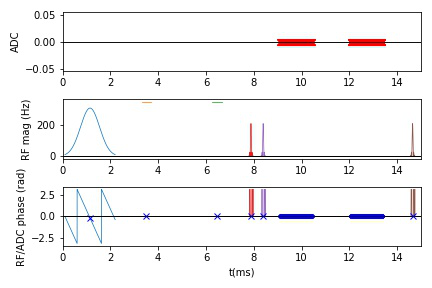

In [1]:
from IPython.display import display
from PIL import Image

path='Spiral3Dream_1.jpg'
display(Image.open(path))

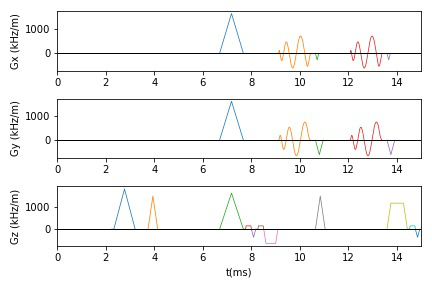

In [2]:
path='Spiral3Dream_2.jpg'
display(Image.open(path))

## save sequence and write sequence & protocol to scanner exchange folder

In [101]:
if seq_dest=='sim': # save to simulation folder
    seq.write('/mnt/pulseq/external.seq')
elif seq_dest=='scanner':
    Path("../Pulseq_sequences/"+date).mkdir(parents=True, exist_ok=True) # create new directory if needed
    seq.write("../Pulseq_sequences/"+date+"/{}.seq".format(filename)) # save seq